# 🏁 Image grid

In [ ]:
#| default_exp utils.tile2d

In [ ]:
# |hide

from nbdev.showdoc import *
from matplotlib import pyplot as plt
from lovely_numpy import lo


In [ ]:
# |hide
# |export
from math import floor, ceil, log2
import numpy as np
from lovely_numpy.utils.pad import pad_frame_gutters


In [ ]:
# |hide
from io import BytesIO

In [ ]:
# |hide
number_images = []

for i in range(100):

    fig, ax = plt.subplots(figsize=(1,1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor("lightblue")

    ax.spines.clear()
    ax.text(0.5, 0.5, f"{i}", va="center", ha="center", size=32, c="blue")
    fig.tight_layout(pad=0, w_pad=0, h_pad=0) # tight_layout() after we are done plotting.

        
    data_obj = BytesIO()

    fig.savefig(data_obj, format="raw", dpi=64)
    plt.close(fig)
    # img_tensor = torch.tensor(
    img_array = np.frombuffer(data_obj.getvalue(), dtype=np.uint8)
    number_images.append( (img_array.reshape((64, 64, 4)) / 255)[:,:,:3] )

number_images = np.stack(number_images)

In [ ]:
lo(number_images)

array[100, 64, 64, 3] n=1228800 x∈[0., 1.000] μ=0.784 σ=0.171

In [ ]:
# number_images[10].rgb(cl=True)

In [ ]:
# |exporti

def fit_columns(t: np.ndarray, # Tensor with images, shape=(n,h,w,c)
                view_width=966):
    """Find out how many colums and rows to use to display the images"""
    
    assert t.ndim == 4
    # Let's figure out how many images can we put in a row without the need for
    # re-scaling. Let's try to keep the number as power or 2 if we have to have
    # multiple rows.
    
    n_img = t.shape[0]
    width = t.shape[-2]
    
    if not n_img or not width: return (0, 0)

    n_cols = 2**floor(log2((view_width / width)))

    # At least 1 image per row, even if it does not fit the view without rescaling.
    n_cols = max(1, n_cols)

    # But if we actually don't have enough images to fill a single
    # power-of-two row, just display as many as we got.
    n_cols = min(n_img, n_cols)
    
    n_rows = ceil(n_img / n_cols) # Last row might have free space.
    
    # Avoid producing tilings that are very wide and short.
    while n_rows < n_cols/3:
        n_cols //=2
        n_rows = ceil(n_img / n_cols)

    return (n_rows, n_cols)

In [ ]:
#| hide
fit_columns(number_images)

(13, 8)

In [ ]:
t = number_images

In [ ]:
n_images = t.shape[0]
n_channels = t.shape[-1]
xy_shape = t.shape[1:3]

n_rows, n_cols = fit_columns(t, view_width=966)

In [ ]:


# We need to form the images inro a rectangular area. For this, we might
# need to add some dummy images to the last row, whoch might be not be full.
n_extra_images = n_rows*n_cols - t.shape[0]
if n_extra_images:
    extra_images = np.ones((n_extra_images, *t.shape[1:]))
    # extra_images = torch.ones((n_extra_images, *t.shape[1:]))
    t = np.concatenate([ t, extra_images ])


In [ ]:
lo(t)

array[104, 64, 64, 3] n=1277952 x∈[0., 1.000] μ=0.792 σ=0.173

In [ ]:

# This is where the fun begins! Imagine 't' is tensor[20, 128, 128, 3].
# and we want 5 rows, 4 columns each.

t = t.reshape(n_rows, n_cols, *t.shape[-3:])
# Now t is tensor[5, 4, 128, 128, 3]

t = t.transpose(0, 2, 1, 3, 4)
# now t is tensor[5, 128, 4, 128, 3]
# If we just squick dimensions 0,1 and 2,3 togerther, we get the image we want.
t = t.reshape(n_rows*xy_shape[0], n_cols*xy_shape[1], n_channels)


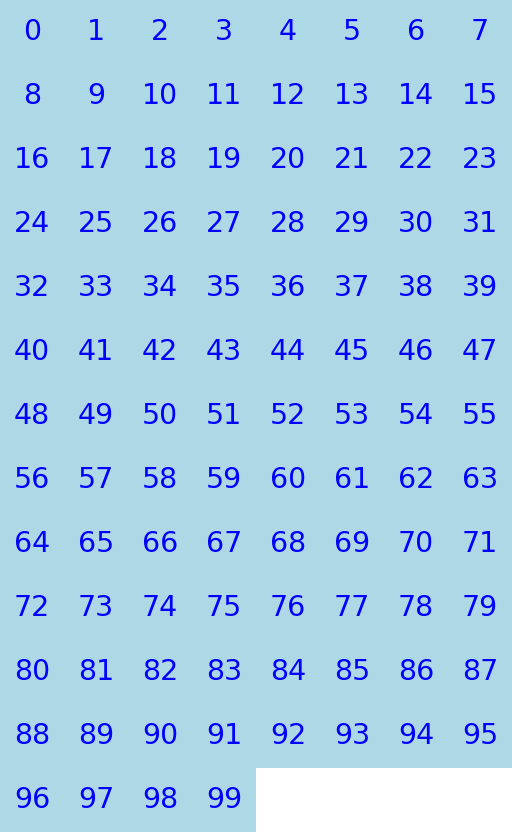

In [ ]:
lo(t).rgb(cl=1)

In [ ]:
#| export

def tile2d(t: np.ndarray,      # Array containing images, shape=(n,h,w,c)
            view_width=966):   # Try to protuce an images at most this wide
    """
    Tile images in a grid.
    """
    assert t.ndim == 4
    # assert t.shape[-1] in (3, 4) # Either RGB or RGBA.

    
    n_images = t.shape[0]
    n_channels = t.shape[-1]
    xy_shape = t.shape[1:3]

    n_rows, n_cols = fit_columns(t, view_width=view_width)

    # We need to form the images inro a rectangular area. For this, we might
    # need to add some dummy images to the last row, whoch might be not be full.
    n_extra_images = n_rows*n_cols - t.shape[0]
    if n_extra_images:
        extra_images = np.ones((n_extra_images, *t.shape[1:]))
        # extra_images = torch.ones((n_extra_images, *t.shape[1:]))
        t = np.concatenate([ t, extra_images ])
    
    # This is where the fun begins! Imagine 't' is tensor[20, 128, 128, 3].
    # and we want 5 rows, 4 columns each.
    
    t = t.reshape(n_rows, n_cols, *t.shape[-3:])
    # Now t is tensor[5, 4, 128, 128, 3]

    t = t.transpose(0, 2, 1, 3, 4)
    # now t is tensor[5, 128, 4, 128, 3]
    # If we just squick dimensions 0,1 and 2,3 togerther, we get the image we want.
    t = t.reshape(n_rows*xy_shape[0], n_cols*xy_shape[1], n_channels)
    
    # Now t is tensor[640, 512, 3], channel-last.
    
    return t

In [ ]:
lo(tile2d(number_images[:17]))

array[192, 512, 3] n=294912 x∈[0., 1.000] μ=0.852 σ=0.160

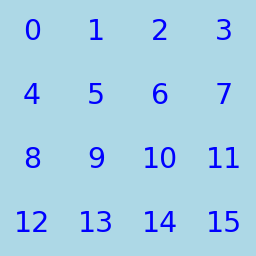

In [ ]:
lo(tile2d(number_images[:16])).rgb

Combine with `utils.pad.pad_frame_gutters` to make it look better

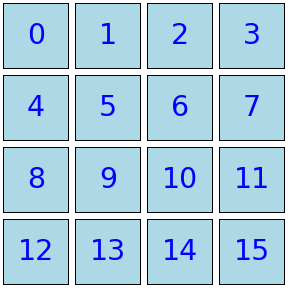

In [ ]:
lo(tile2d(pad_frame_gutters(number_images[:16]), view_width=1200)).rgb

In [ ]:
# |export
def hypertile(t: np.ndarray, #torch.Tensor, # input tensor, shape=([...], B, H, W, C)
            frame_px=1,        # Frame width for the innermost group
            gutter_px=3,       # Gutter width for the innermost group
            view_width=966):   # Try to protuce an images at most this wide

    "Recursively tile images on a 2d grid"

    assert t.ndim >= 4, f"Tiling requires at least 3 dimensions: H, W, C. got {t.shape}"
    level = t.ndim - 3

    if t.ndim > 4:
        tlist = list(t)
        sub_view_width = view_width - (gutter_px - frame_px) * level * 2
        tiles = [ hypertile(item,
                            frame_px=frame_px,
                            gutter_px=gutter_px,
                            view_width=sub_view_width)
                  for item in tlist ]
        t = np.stack(tiles)

    return tile2d(pad_frame_gutters(t,
                                     frame_px=frame_px*level,
                                     gutter_px=gutter_px*level),
                    view_width=view_width)

In [ ]:
hyperimages = number_images.reshape(2, 5, 10, 64, 64, 3)
lo(hyperimages)

array[2, 5, 10, 64, 64, 3] n=1228800 x∈[0., 1.000] μ=0.784 σ=0.171

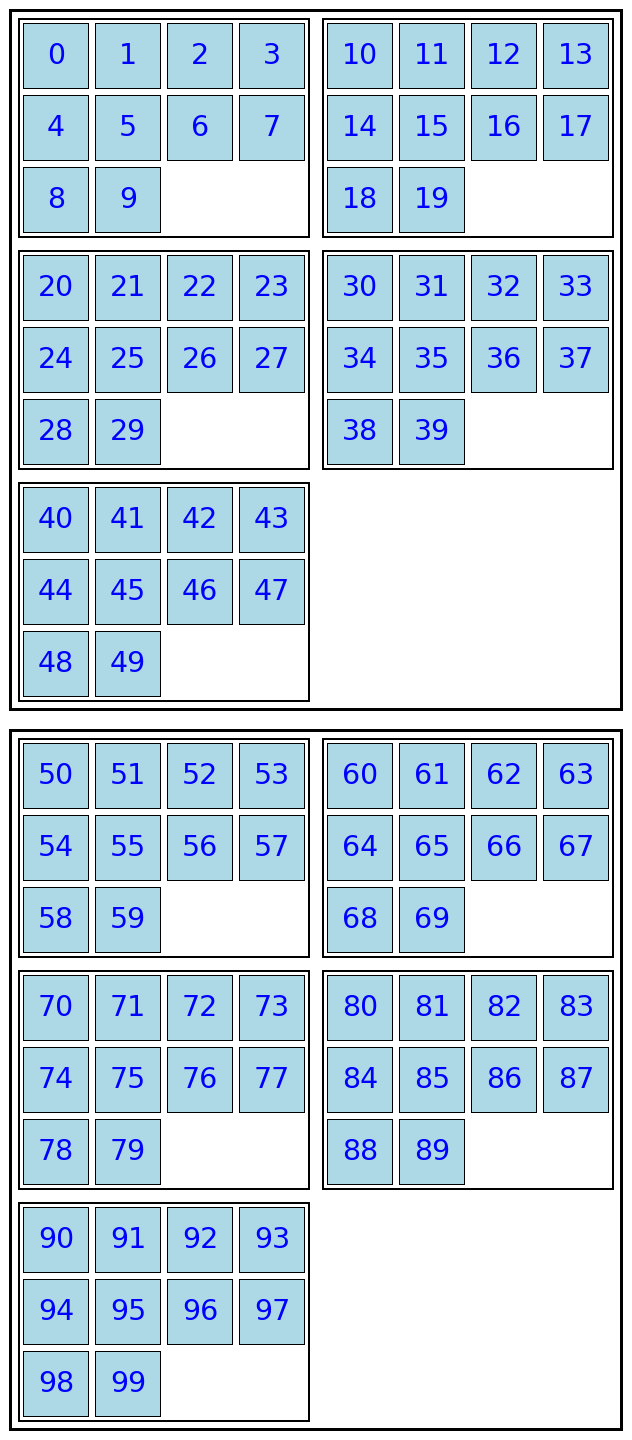

In [ ]:
lo(hypertile(hyperimages)).rgb

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()